# Splice junction correlations beteween scSLR and SS2

In [1]:
!date

Mon Oct 21 01:50:56 PDT 2024


In [2]:
!echo $CONDA_PREFIX

/c4/home/derek/miniconda3/envs/scquint_4


In [3]:
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import anndata

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
from scquint.data import load_adata_from_starsolo, add_gene_annotation, group_introns

from scquint.data import calculate_PSI

### load scSLR data from h5ad

In [5]:
# adata_SLR = sc.read_h5ad('/c4/home/derek/data1/derek/data_scSLR/prenatal_brain/adata_spl.h5ad')

adata_SLR= sc.read_h5ad('/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/adata_spl_equal.h5ad')

In [6]:
simplify_dict = {'Astrocyte': 'Astrocyte',
 'EN-PFC': 'EN-PFC',
 'EN-V1': 'EN-V1',
 'Endothelial': 'Endothelial',
 'Glyc': 'Glyc',
 'IN-CTX-CGE': 'IN-CTX-CGE',
 'IN-CTX-MGE': 'IN-CTX-MGE',
 'IN-STR': 'IN-STR',
 'IPC-div': 'IPC-nEN',
 'IPC-nEN': 'IPC-nEN',
 'MGE-IPC': 'MGE-IPC',
 'MGE-RG': 'MGE-RG',
 'MGE-div': 'MGE-RG',
 'Microglia': 'Microglia',
 'Mural': 'Mural',
 'OPC': 'OPC',
 'RG': 'RG',
 'RG-div': 'RG',
 'RBC': 'RBC',
 'nEN': 'nEN',
 'nIN': 'nIN'}

adata_SLR.obs['C_scANVI_simple'] = adata_SLR.obs.C_scANVI_simple.map(simplify_dict)

In [7]:
adata_SS3 = sc.read_h5ad('/c4/home/derek/data1/derek/data_scSLR/prenatal_brain/NOW_2017_SS2/scQuint_SS2.h5ad')
                                              

In [8]:
adata_SS3.obs

,WGCNAcluster,Name,Age_in_Weeks,RegionName,Laminae,Area,C_scANVI_simple
Hi_GW16_1-Hi_GW16_1,nEN-early2,Sample2,14.0,Cortex,SVZ,0,nEN
Hi_GW16_10-Hi_GW16_10,IN-CTX-CGE1,Sample2,14.0,Cortex,SVZ,0,IN-CTX-CGE
Hi_GW16_11-Hi_GW16_11,vRG,Sample2,14.0,Cortex,SVZ,0,RG-div
Hi_GW16_12-Hi_GW16_12,nEN-early2,Sample2,14.0,Cortex,VZ,0,nEN
Hi_GW16_13-Hi_GW16_13,vRG,Sample2,14.0,Cortex,VZ,0,RG
...,...,...,...,...,...,...,...
S96-G6,nEN-late,Sample38,14.0,Cortex,All,V1,IPC-nEN
S96-G9,EN-V1-3,Sample38,14.0,Cortex,All,V1,EN-V1
S96-H11,NaN,Sample38,14.0,Cortex,All,V1,nEN
S96-H2,nEN-early2,Sample38,14.0,Cortex,All,V1,nEN


In [9]:
# Here's a scatter plot of mean PSI where each point corresponds to an intron,cell_type pair, and the x-axis could be mean PSI in 
# SMARTseq and y-axis in SLR. The introns are those appear in both SMARTseq and SLR data. To make sure the mean of PSI are representative, we only
# plot the introns with PSI is defined in more than n=10 cells of thecell cluster. The Pearson correlation here is 0.926. This shows that for matched introns in both datasets, 
# mean PSIs of intron in each cell type cluster in one dataset are al so highly correlated with another.

In [10]:
%%time
adata_SLR.layers["PSI_raw"] = calculate_PSI(adata_SLR)

/c4/home/derek/bin/scquint/scquint/data.py:212: RuntimeWarning: invalid value encountered in divide
  return X / intron_group_sums[:,groups]


In [11]:
%%time
adata_SS3.layers["PSI_raw"] = calculate_PSI(adata_SS3)

In [12]:
##rename SS3 celltype annotations

In [13]:
%%time
marker_genes = adata_SLR.var.index.intersection(adata_SS3.var.index).tolist()

genedf_SLR = sc.get.obs_df(
        adata_SLR,
        keys=["C_scANVI_simple", *marker_genes],
    layer='PSI_raw'
)
    
    


CPU times: user 1min 35s, sys: 1min 9s, total: 2min 44s
Wall time: 2min 45s


In [14]:
len(marker_genes)

34997

In [15]:
%%time
df_SLR=pd.Series()

for celltype in genedf_SLR.C_scANVI_simple.unique():
    
    genedf_SLR_ = genedf_SLR[genedf_SLR.C_scANVI_simple == celltype]
    
    genedf_SLR_.dropna(thresh = 10,
                 axis=1,inplace=True)

    means = genedf_SLR_.mean(axis=0)
    
   # means.name = celltype
    means.index = means.index.astype(str) + '_' + celltype
    
    df_SLR = df_SLR.append(means,
                  # ignore_index=True
                  )
    

<timed exec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>

CPU times: user 1min 43s, sys: 23.2 s, total: 2min 7s
Wall time: 2min 7s


<timed exec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
%%time
# marker_genes = adata_SLR.var.index.intersection(adata_SS3.var.index).tolist()

genedf_SS3 = sc.get.obs_df(
        adata_SS3,
        keys=["C_scANVI_simple", *marker_genes],
    layer='PSI_raw'
)

CPU times: user 4.34 s, sys: 1.01 s, total: 5.35 s
Wall time: 5.38 s


In [17]:
%%time
df_SS3=pd.Series()

for celltype in genedf_SS3.C_scANVI_simple.unique():
    
    genedf_SS3_ = genedf_SS3[genedf_SS3.C_scANVI_simple == celltype]
    
    genedf_SS3_.dropna(thresh = 10,
                 axis=1,inplace=True)

    means = genedf_SS3_.mean(axis=0)
    
    #means.name = celltype
    means.index = means.index.astype(str) + '_' + celltype
    
    df_SS3 = df_SS3.append(means,
                  # ignore_index=True
                  )
    

<timed exec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>

CPU times: user 5.26 s, sys: 525 ms, total: 5.78 s
Wall time: 5.8 s


<timed exec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [18]:
df_SS3 = df_SS3[df_SS3.index.isin(df_SLR.index)]

In [19]:
df_SLR = df_SLR[df_SLR.index.isin(df_SS3.index)]

In [20]:
corr = df_SLR.corr(df_SS3,method = 'pearson')

In [21]:
corr

0.9323504717466924

In [22]:
df_SS3

NOC2L_chr1:944801-945041_nEN          0.318182
NOC2L_chr1:944801-945056_nEN          0.681818
INTS11_chr1:1312369-1312439_nEN       0.933333
INTS11_chr1:1315619-1319295_nEN       1.000000
CCNL2_chr1:1388066-1388491_nEN        0.105792
                                        ...   
BEX3_chrX:103376614-103377509_RBC     0.002635
BEX3_chrX:103377107-103377462_RBC     0.935897
BEX3_chrX:103377107-103377509_RBC     0.997365
SSR4_chrX:153794755-153796433_RBC     0.993900
RPL10_chrX:154399942-154400701_RBC    0.028696
Length: 198819, dtype: float64

In [23]:
df_SLR

INTS11_chr1:1315619-1319295_IPC-nEN      1.000000
CCNL2_chr1:1388066-1388491_IPC-nEN       0.022727
MRPL20_chr1:1402257-1402461_IPC-nEN      0.011299
MRPL20_chr1:1405887-1406225_IPC-nEN      0.018018
CDK11B_chr1:1649638-1652438_IPC-nEN      0.901042
                                           ...   
COX7B_chrX:77899594-77902642_Mural       1.000000
TCEAL9_chrX:103356607-103357614_Mural    0.550000
BEX3_chrX:103376614-103377509_Mural      0.024390
BEX3_chrX:103377107-103377509_Mural      0.722222
RPL10_chrX:154399942-154400701_Mural     0.060829
Length: 198819, dtype: float64

Text(0, 0.5, 'Ψ scSLR-seq')

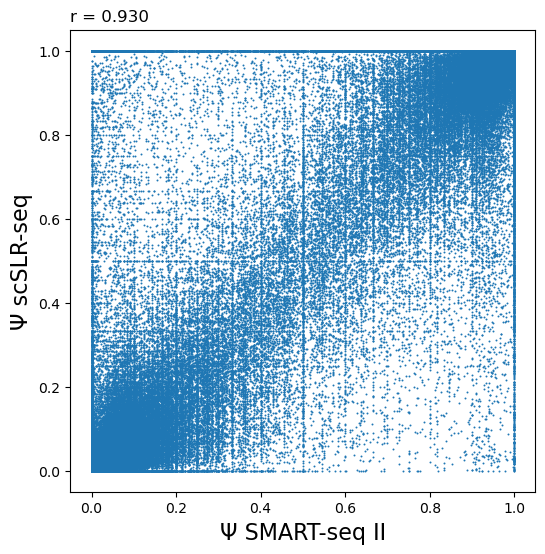

In [24]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.scatterplot(x=df_SS3,
                y=df_SLR,
                s=2,
                linewidth=0,
                ax=ax
                
               )

# ax.spines.right.set_visible(False)
# ax.spines.top.set_visible(False)

ax.set_title('r = 0.930',loc='left')

ax.set_xlabel('Ψ SMART-seq II', fontsize=16)
ax.set_ylabel('Ψ scSLR-seq', fontsize=16)



# sns.kdeplot(
#     data=tips,
#     x=df_SS3,
#     y=df,
#     levels=10,
#     fill=True,
#     alpha=1,#0.6,
#     cut=0,
#     ax=ax,
#    # clip
# )

In [25]:
data = pd.concat([df_SS3,df_SLR],axis=1)

In [26]:
data.columns = ['SS2','SLR']

Text(0.5, 0, 'Ψ scSLR-seq')

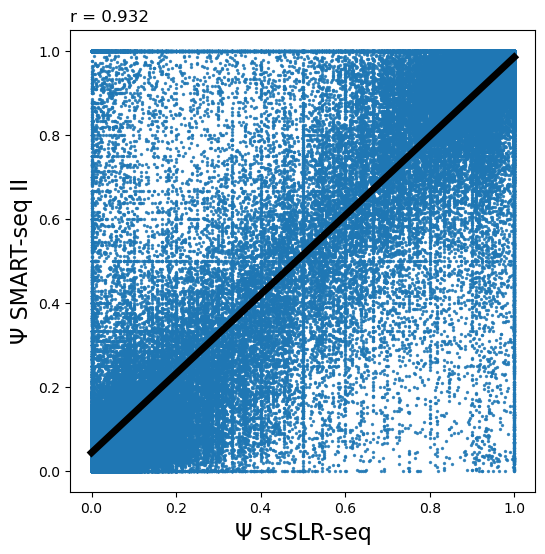

In [27]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.regplot(data = data,
            x='SS2',
            y='SLR',
            scatter_kws={'s':2},#, 'linewidth':0},
            line_kws={"lw":5, 'color':'black'},
            ax=ax
                
               )

# ax.spines.right.set_visible(False)
# ax.spines.top.set_visible(False)

ax.set_title(f'r = {round(corr,3)}',loc='left')

ax.set_ylabel('Ψ SMART-seq II', fontsize=16)
ax.set_xlabel('Ψ scSLR-seq', fontsize=16)



In [28]:
from scipy import stats

In [29]:
# %%time
# # very slow 
# values = np.vstack([df_SS3, df_SLR])
# kernel = stats.gaussian_kde(values)(values)

# idx = kernel.argsort()
# x, y, z = df_SLR[idx], df_SS3[idx], kernel[idx]

# kernel.argsort()

In [30]:
# fig, ax = plt.subplots(figsize=(6, 6))

# sns.scatterplot(
#     x=x,
#     y=y,
#     c=z,
#     s=20,
#     cmap="plasma",
#     ax=ax,
#     linewidth=0,
#     alpha=.6
# )

# # ax.spines.right.set_visible(False)
# # ax.spines.top.set_visible(False)

# # ax.spines.bottom.set_linewidth(2)
# # ax.spines.left.set_linewidth(2)


# ax.set_title(f"r = {round(corr,4)}",loc='left')

# ax.set_ylabel('Ψ SMART-seq III', fontsize=16)
# ax.set_xlabel('Ψ scSLR-seq', fontsize=16)

# #fig.savefig('SLR_SS3_PBMC.pdf')

In [31]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

/scratch/derek/ipykernel_1510923/4010128964.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('bone_r', 100)


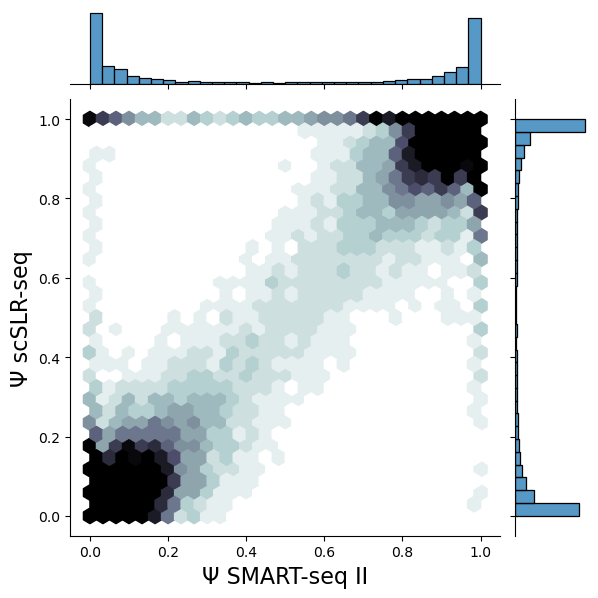

In [75]:
cmap = cm.get_cmap('bone_r', 100)
newcmp = ListedColormap(cmap(np.linspace(0, 75, 1024)))

ax=sns.jointplot(data = data,
                x='SS2',
                y='SLR',
              #kind="hex", 
              #color="#4CB391",
              kind='hex', 
              cmap= newcmp,
              joint_kws=dict(gridsize=30),
             )

#h.ax_marg_x()

ax.set_axis_labels('Ψ SMART-seq II', 'Ψ scSLR-seq', fontsize=16)
#ax.savefig('./plots/SLR_SSII_cor.pdf')

# ax.set_title(f"r = {round(corr,4)}",loc='left')

# ax.set_ylabel(, fontsize=16)
# ax.set_xlabel(, fontsize=16)



# h.ax_joint.cla()
# plt.sca(ax.ax_joint)

# plt.hist2d(data['SS2'],data['SLR'],bins=100,norm=mpl.colors.LogNorm(),cmap=cmap)


/scratch/derek/ipykernel_1510923/604185965.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('bone_r', 100)


Text(0.5, 0, 'Ψ SMART-seq II')

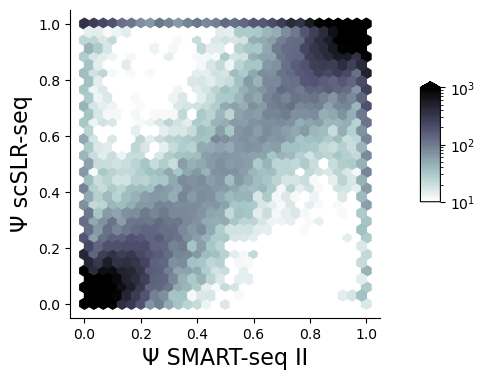

In [207]:
fig, ax = plt.subplots(1,1,figsize=(4,4))

cmap = cm.get_cmap('bone_r', 100)

im = plt.hexbin(data['SS2'],data['SLR'], norm=mpl.colors.LogNorm(vmin=10,vmax=1000),cmap=cmap, gridsize=30)


cbar_ax = fig.add_axes([1, 0.4, 0.05, 0.3])
fig.colorbar(im, cax=cbar_ax, extend='max')


ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_ylabel('Ψ scSLR-seq', fontsize=16) 
ax.set_xlabel('Ψ SMART-seq II', fontsize=16) 

# fig.savefig('./plots/SLR_SSII_cor_3.pdf')


In [61]:
def makesweetgraph(x=None, y=None, cmap='jet', ylab=None, xlab=None, bins=100, sets=sets, figsize=(5,4), snsbins=60):
    set1,set2 = sets
    ax1 = sns.jointplot(x=x, y=y,marginal_kws=dict(bins=snsbins))
    ax1.fig.set_size_inches(figsize[0], figsize[1])
    ax1.ax_joint.cla()
    plt.sca(ax1.ax_joint)
    plt.hist2d(x,y,bins,norm=mpl.colors.LogNorm(),cmap=cmap)
    plt.title('%s vs %s (%.4f%% of loci)\n%s and %s' % (xlab,ylab,(len(x)/numsnps)*100,set1,set2),y=1.2,x=0.6)
    plt.ylabel(ylab,fontsize=12)
    plt.xlabel(xlab,fontsize=12)
    cbar_ax = ax1.fig.add_axes([1, 0.1, .03, .7])
    cb = plt.colorbar(cax=cbar_ax)
    cb.set_label(r'$\log_{10}$ density of points',fontsize=13)

NameError: name 'sets' is not defined

In [60]:
import matplotlib as mpl

In [ ]:
from scquint.differential_splicing import find_marker_introns

In [ ]:
sig_diff_spl_intron_groups = pd.read_csv("/c4/home/derek/data1/derek/data_scSLR/PBMC/diff_intron_groups_SLR")

sig_diff_spl_introns = pd.read_csv("/c4/home/derek/data1/derek/data_scSLR/PBMC/diff_introns_SLR")

In [ ]:
input_dir = output_dir= '/c4/home/derek/data1/derek/data_scSLR/PBMC/'
adata_exp = sc.read_h5ad(input_dir+'gene_expression.h5ad')

In [ ]:
adata_SLR = adata_SLR[:,adata_SLR.var['gene_name'].isin(adata_exp.var_names)]

In [ ]:
adata_exp.var_names_make_unique()

sc.pp.normalize_total(adata_exp, target_sum=1e6)
sc.pp.log1p(adata_exp)

In [ ]:
marker_introns = find_marker_introns(
    sig_diff_spl_intron_groups, sig_diff_spl_introns, 5000, 
    max_p_value_adj=0.05,
    min_delta_psi=0,
)

In [ ]:
temp=[]

for key in marker_introns.keys():
    genes = marker_introns[key]
    count = len(genes)
    print(count)
    temp.append(count)
    
sum(temp)

In [ ]:
SLR = pd.DataFrame()
EXP = pd.DataFrame()


for key in marker_introns.keys():
    
    introns = marker_introns[key]
    introns = [i for i in introns if i in adata_SLR.var_names]
    
    spec_SLR = sc.get.obs_df(
        adata_SLR,
        keys=["ct1", *introns],
        layer='PSI_raw')
    
    spec_SLR = spec_SLR[spec_SLR["ct1"] == key].mean(numeric_only=True)
    
    SLR = pd.concat([SLR,spec_SLR])
    
    
    
    
    genes = []
    for intron in introns:
        gene=intron.split('_')[0]
        genes.append(gene)
    
    genes = [i for i in genes if i in adata_exp.var_names]
    spec_exp = sc.get.obs_df(
        adata_exp,
        keys=["ct1", *genes],
    )
    
    spec_exp = spec_exp[spec_exp["ct1"] == key].mean(numeric_only=True)
    
    EXP = pd.concat([EXP,spec_exp])

In [ ]:
x=EXP.reset_index()[0]
y=SLR.reset_index()[0]

In [ ]:
corr = x.corr(y,'pearson')

In [ ]:
print(x.shape)
print(y.shape)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.regplot(#data = data,
            x=x,
            y=y,
            scatter_kws={'s':20, 'linewidth':0},
            line_kws={"lw":5, 'color':'black'},
            ax=ax,
            color='grey'
                
               )

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

ax.set_title(f'r = {round(corr,4)}',loc='left')

ax.set_ylabel('Ψ scSLR-seq', fontsize=16)
ax.set_xlabel('$Expression (log_{10} TPM)$', fontsize=16)

In [ ]:
adata_SS3

In [ ]:
adata_SLR

In [ ]:

SS3= pd.DataFrame()
SLR = pd.DataFrame()

for key in marker_introns.keys():
    
    introns = marker_introns[key]
    introns = [i for i in introns if i in list(set(adata_SS3.var_names) & set(adata_SLR.var_names))]
    
    spec_SS3 = sc.get.obs_df(
        adata_SS3,
        keys=["ct1", *introns],
        layer='PSI_raw')
    
    spec_SS3 = spec_SS3[spec_SS3["ct1"] == key].mean(numeric_only=True)
    
    SS3 = pd.concat([SS3,spec_SS3])
    
    
    
    spec_SLR = sc.get.obs_df(
        adata_SLR,
        keys=["ct1", *introns],
        layer='PSI_raw')
    
    spec_SLR = spec_SLR[spec_SLR["ct1"] == key].mean(numeric_only=True)
    
    SLR = pd.concat([SLR,spec_SLR])

In [ ]:
x=SS3.reset_index()[0]
y=SLR.reset_index()[0]

In [ ]:
corr = x.corr(y,'spearman')

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.regplot(data = data,
            x=x,
            y=y,
            scatter_kws={'s':20, 'linewidth':0},
            line_kws={"lw":5, 'color':'black'},
            ax=ax,
            color='grey'
            
                
               )

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

ax.set_title(f'r = {round(corr,4)}',loc='left')

ax.set_ylabel('Ψ SMART-seq II', fontsize=16)
ax.set_xlabel('Ψ scSLR-seq', fontsize=16)

In [ ]:
!conda list